# Bike Sharing Demand

- 가영 
- 2021.10.21 발표
- t-test, ANOVA 에 대하여
- 제 주관으로 몇몇 코드는 제거되었으니,, 기존 코드와 함께 확인하세욤 : ) 

https://sullma6643.notion.site/sullma6643/177807e85c2b4973b5b64589724dfd9b

## 시간당 자전거 대여량을 예측하기

## 프로젝트 시작일: 10/05/2021 ~


## 컬럼 설명

(데이터 다운로드: https://www.kaggle.com/c/bike-sharing-demand/data)

  * **datetime** - 시간. 연-월-일 시:분:초 로 표현합니다.(ex. 2018-11-01 00:00:00) 
  * **season** - 계절. 봄(1), 여름(2), 가을(3), 겨울(4) 순으로 표현합니다.
  * **holiday** - 공휴일. 1이면 공휴일이며, 0이면 공휴일이 아닙니다.
  * **workingday** - 근무일. 1이면 근무일이며, 0이면 근무일이 아닙니다.
  * **weather** - 날씨. 1 ~ 4 사이의 값을 가지며, 구체적으로는 다음과 같습니다.
    * 1: 아주 깨끗한 날씨입니다. 또는 아주 약간의 구름이 끼어있습니다.
    * 2: 약간의 안개와 구름이 끼어있는 날씨입니다.
    * 3: 약간의 눈, 비가 오거나 천둥이 칩니다.
    * 4: 아주 많은 비가 오거나 우박이 내립니다.
  * **temp** - 온도. 섭씨(Celsius)로 적혀있습니다.
  * **atemp** - 체감 온도. 마찬가지로 섭씨(Celsius)로 적혀있습니다.
  * **humidity** - 습도.
  * **windspeed** - 풍속.
  * **casual** - 비회원(non-registered)의 자전거 대여량.
  * **registered** - 회원(registered)의 자전거 대여량.
  * **count** - 총 자전거 대여랑. 비회원(casual) + 회원(registered)과 동일합니다.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [2]:
# train.csv 파일 읽어오기
train = pd.read_csv('/content/drive/MyDrive/Bigdata_study/딥러닝스터디-빅분기/자전거수요예측/bike-sharing-demand/train.csv')
#/content/drive/MyDrive/Bigdata_study/딥러닝스터디-빅분기/자전거수요예측/bike-sharing-demand/train.csv
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# teste.csv 파일 읽어오기
test = pd.read_csv('/content/drive/MyDrive/Bigdata_study/딥러닝스터디-빅분기/자전거수요예측/bike-sharing-demand/test.csv')
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# Preprocessing

In [4]:
# 판다스의 to_datetime을 활용해 datetime 컬럼의 타입을 문자열(String)에서 날짜/시간(datetime) 데이터로 바꿔주기
train['datetime'] = pd.to_datetime(train['datetime'])

# train 데이터에 연, 월, 일, 시, 요일명을 나타내는 새로운 컬럼을 생성하기
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.day_name()

# test 데이터도 train 데이터와 마찬가지로 datetime 데이터로 바꿔주기
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.day_name()


# 파생변수 생성 

### 체감온도와 실제 온도의 관계에 대한 고찰

공식은 체감온도(℃)=13.12+0.6215×T-11.37V0.16+0.3965V0.16×T이다.

여기서 T는 기온, V는 지상 10m 지점에서의 풍속을 의미
1시간당 몇km를 가는 바람인지를 측정, 공식 대입하면 체감온도 산출

영하 10℃에서 풍속이 5km/h일 때 체감온도는 영하 13℃ 지만, 풍속이 30km/h가되면 체감온도가 영하 20℃까지 떨어져 강한 추위를 느끼게 된다.

→ 1시간 단위로 구성된 데이터셋 내에서 풍속, 기온, 체감온도 세 변수는 서로 밀접한 관계가 있음.

참고자료 : [체감온도와 실제 온도의 차이는?](https://www.sciencetimes.co.kr/news/%EC%B2%B4%EA%B0%90%EC%98%A8%EB%8F%84%EC%99%80-%EC%8B%A4%EC%A0%9C-%EC%98%A8%EB%8F%84%EB%8A%94-%EC%96%B4%EB%96%BB%EA%B2%8C-%EB%8B%A4%EB%A5%B8%EA%B0%80/)

### 불쾌지수

- [불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32]
- 기온과 상대습도의 단위는 각각 ℃, %
- 그럼 주어진 데이터 셋의 temp와 humidity 는 기온과 상대습도가 맞는지?
- 주어진 데이터는 Capital Bikeshare의 데이터 (즉, 워싱턴 D.C. 에서 발생한 데이터)  
→ __1957년 미국의 E. C. Thom에 의해 고안된 식__으로 불쾌지수 산출

불쾌지수 = 1.4T-0.55(1-RH)(1.4T-26)+32 (T:기온(℃), RH:상대습도(%))

- 워싱턴 연간 날씨에 대해 찾아보니까 어느정도 매치가 되었음 (구글, 연간 워싱턴 날씨 검색)

In [5]:
# 불쾌지수 변수 생성
# 습도는 %단위로 데이터가 구성되어 있어 0.xx로 변환하기 위해 100으로 나누어줌
train['discomfort_index'] = 1.8*train['temp'] - 0.55*(1-train['humidity']/100)*(1.8*train['temp'] - 26) + 32
test['discomfort_index'] = 1.8*test['temp'] - 0.55*(1-test['humidity']/100)*(1.8*test['temp'] - 26) + 32

# 소수점 뒷부분 반올림
train['discomfort_index'] = train['discomfort_index'].round(2)
test['discomfort_index'] = test['discomfort_index'].round(2)

train.loc[:,['temp', 'humidity', 'discomfort_index']].head(10)

,temp,humidity,discomfort_index
0,9.84,81,50.58
1,9.02,80,49.31
2,9.02,80,49.31
3,9.84,75,50.85
4,9.84,75,50.85
5,9.84,75,50.85
6,9.02,80,49.31
7,8.20,86,47.63
8,9.84,75,50.85
9,13.12,76,55.93


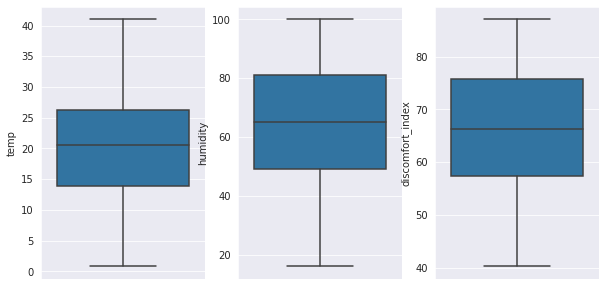

In [6]:
# 온도 vs 습도 vs 불쾌지수 시각화 
figure, ((ax1, ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(10, 5)

sns.boxplot(data=train, y='temp', orient = "v", ax=ax1)
sns.boxplot(data=test, y='humidity', orient = "v", ax=ax2)
sns.boxplot(data=train, y='discomfort_index', orient = "v", ax=ax3)
plt.show()

In [7]:
# 알아보기 쉽게 문자로 바꿔줌
train['season'].replace({1:'spring', 2 : 'summer', 3 : 'fall', 4 : 'winter'}, inplace = True)
test['season'].replace({1:'spring', 2 : 'summer', 3 : 'fall', 4 : 'winter'}, inplace = True)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,discomfort_index
0,2011-01-01 00:00:00,spring,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,Saturday,50.58
1,2011-01-01 01:00:00,spring,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,Saturday,49.31
2,2011-01-01 02:00:00,spring,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,Saturday,49.31
3,2011-01-01 03:00:00,spring,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,Saturday,50.85
4,2011-01-01 04:00:00,spring,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,Saturday,50.85


# EDA 
EDA는 크게 두 가지로 살펴볼 것이다. 
1. 시간대에 따라서 살펴볼 것이다.
2. 날씨와 관련된 변수를 통해 살펴볼 것이다.

### 시간대에 따라 살펴보기

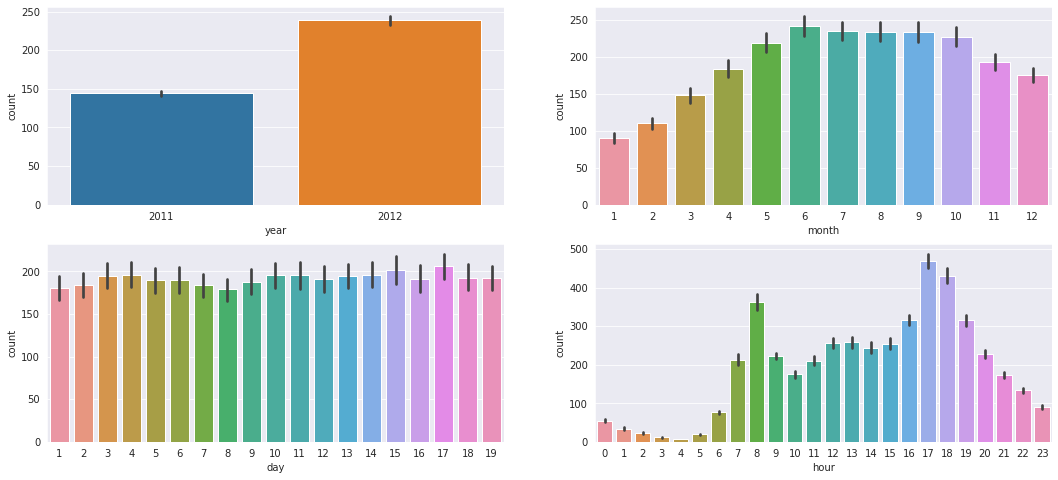

In [8]:
# matplotlib의 subplots를 사용하여 한 화면으로 띄우기
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18, 8)

# seaborn의 barplot으로 subplots의 각 구역에 연, 월, 일, 시 자전거 대여량 출력
sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)

plt.show()

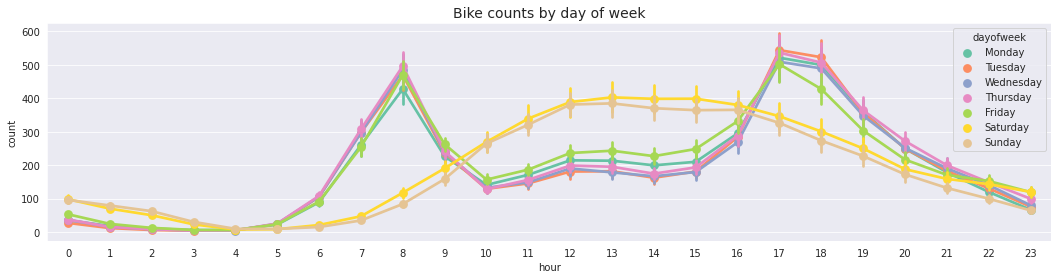

In [9]:
# matplotlib를 활용
plt.figure(figsize = (18, 4))

# 월~일까지의 요일 순서 지정
# dayofweek_order라는 이름의 변수에 할당
dayofweek_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# seaborn의 pointplot으로 dayofweek(요일)과 hour(시간))에 따른 자전거 변화량을 시각화
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", hue_order=dayofweek_order, palette = 'Set2')
plt.title('Bike counts by day of week', size = 14)
plt.show()

### 시각화로 발견할 수 있는 사실
- 이는 근무일 여부에 따라 차이가 나는 것을 볼 수 있다.
- 같은 주말이라고 하더라도 일요일이 토요일보다 자전거 대여량이 낮음 -> 일요일은 다음날이 월요일이기 때문에?
- 같은 주중이라도 금요일이 퇴근하는 시간대(18시 ~ 20시)에 자전거 대여량이 다른 주중에 비해 낮음 -> 불금을 즐기기 위해?
- 금요일은 같은 주중이라고 하더라도 오후 시간대(10시 ~ 16시)에 자전거 대여량이 높음 -> 금요일과 월요일은 주중임에도 불구하고 주말과 끼여있는 요일이기 때문에, 주말의 성향을 어느정도 타는게 아닐까?
- working day, holiday 그래프를 통해 한 번 더 확인해보자.

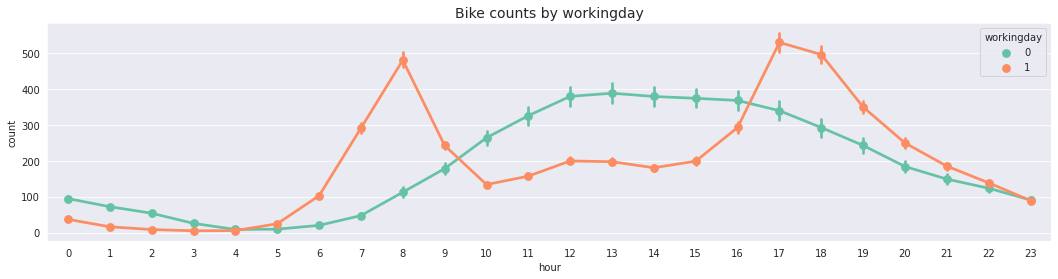

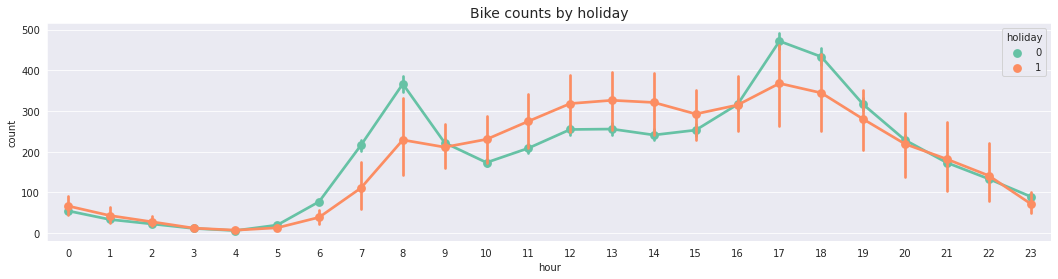

In [10]:
# seaborn의 pointplot으로 workingday(근무일 여부)와 hour(시간)에 따른 자전거 변화량을 시각화
# 확실히 근무하는 날과 근무하지 않는 날의 자전거 대여량이 명확하게 차이가 남

cols = ['workingday', 'holiday']

for col in cols:
    plt.figure(figsize = (18, 4))
    sns.pointplot(data=train, x='hour', y='count', hue=col, palette = 'Set2')
    plt.title('Bike counts by '+ col, size = 14)
    plt.show()

<b> 시각화를 통해 발견한 사실 </b>
- 2012년의 사용량이 2011년보다 많다.
- 날이 따뜻한 6,7,8월의 사용량이 많았고, 겨울의 경우 1월보단 12월의 사용량이 더욱 많았다.
- 일별로 보기엔 19일 밖에 없으므로 보류
- 시간대의 경우, 근무일 여부에 따라 아래와 같은 차이가 났다.
- `working day :  출퇴근 시간대 자전거를 많이 빌림 `
- `holiday : 시간대 자전거를 많이 빌림, 출퇴근 시간대 자전거를 많이 빌림 `

위 두 가지 사실을 통해 파생변수를 생성할 수 있을 것 같다.

In [11]:
# 사용량이 많을 때
# lambda x : [0,1][True일 경우, 1이 반환되므로, [0,1]에서 인덱스 번호가 1인 1이 선택됨]
# lambda x : [0,1][False일 경우, 0이 반환되므로, [0,1]에서 인덱스 번호가 0인 0이 선택됨]
#train['peak'] = train[['hour', 'workingday']].apply(lambda x: [0, 1][(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
#test['peak'] = test[['hour', 'workingday']].apply(lambda x: [0, 1][(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

train['peak'] = train[['hour', 'workingday']].apply(lambda x: [0, 1][(x['workingday'] == 1 and  ( 7 <= x['hour'] <= 9 or 17 <= x['hour'] <= 19))], axis = 1)
test['peak'] = test[['hour', 'workingday']].apply(lambda x: [0, 1][(x['workingday'] == 1 and  ( 7 <= x['hour'] <= 9 or 17 <= x['hour'] <= 19))], axis = 1)


### 날씨와 관련된 변수를 통해 살펴보기

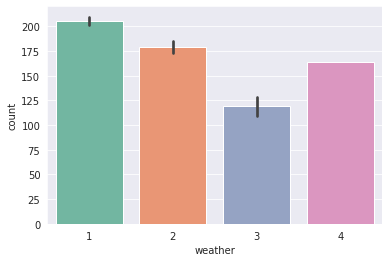

In [12]:
# weather 데이터 시각화하여 자전거 대여량 확인해보기
sns.barplot(data=train, x='weather', y='count', palette = 'Set2')
plt.show()

1 -> 4로 갈수록 날이 험한 것이다. 
- 당연하게도 날이 좋을 때 많이 탄다.
- 4에서 ci (신뢰구간)이 보이지 않는다. 표본이 적은 것으로 보이니 count를 살펴보자

In [13]:
# groupby를 통해 개수 확인
pd.DataFrame(train.groupby('weather')['count'].count())

,count
weather,
1,7192
2,2834
3,859
4,1


4의 표본이 1이므로 3으로 대체해준다.

In [14]:
# 대체해줌.
train['weather'].replace({4 : 3}, inplace = True)

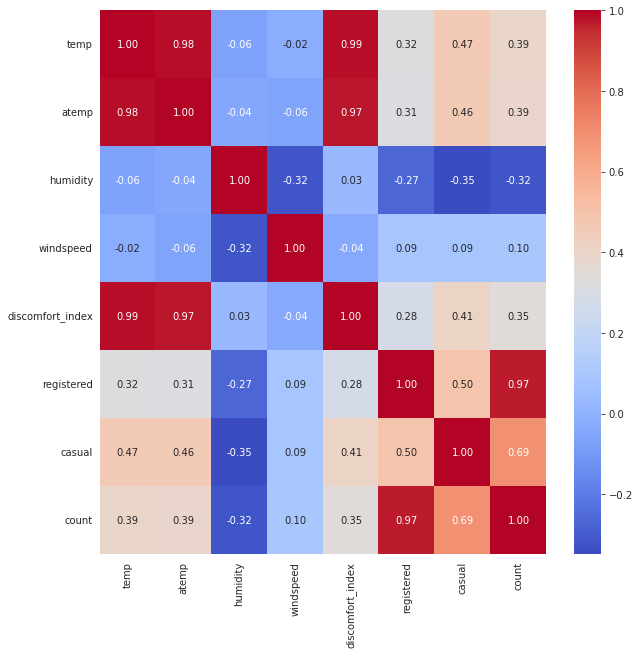

In [15]:
# 상관계수 행렬
plt.figure(figsize = (10,10))

numeric = ['temp', 'atemp', 'humidity', 'windspeed', 'discomfort_index', 'registered', 'casual', 'count']
train_numeric = train.loc[:, numeric]
sns.heatmap(train_numeric.corr(), cmap = 'coolwarm', annot = True, fmt= '.2f')
plt.show()

- registered, casual이 눈에 띈다. registered + casual = count이므로 높은 상관관계를 보인 것으로 보인다.
- 절댓값 기준 hour, temp, atemp, humidty순이다.
- temp와 atemp가 __다중공선성__이 보이므로 살펴보자.


- __분석 결과 추가__
- 상관분석은 피어슨 상관계수를 기반으로 한 분석기법이므로 수치형 변수끼리 관계를 보는 것이 옳다고 판단
- 불쾌지수가 자전거 대여량과 높은 상관관계를 갖는다. 대여량 중에서도 비회원 대여량과 불쾌지수가 높은 상관관계를 가진다.
- 공유 자전거 대여량이 기상 관측 데이터 중에서도 온도, 체감온도, 불쾌지수와 밀접한 관련이 있을 것으로 추정
- `시간` 데이터는 어떻게? -> 시간이 연속적이지 못해서 시계열로 볼 수 없다.

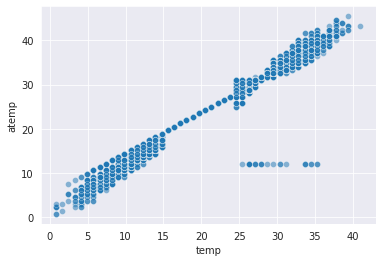

In [16]:
# seaborn의 scatterplot으로 temp(온도)와 atemp(체감온도)의 상관관계를 시각화
sns.scatterplot(data=train, x='temp', y='atemp', alpha = .5)
plt.show()

오른쪽 하단의 일자로 이루어진 scatter들을 자세히 살펴보자.

In [17]:
# temp, atemp 값을 쉽게 확인하기 위해 plotly 라이브러리 사용
import plotly.express as px
px.scatter(data_frame=train, x= 'temp', y= 'atemp', facet_col = 'season', color = 'season')

확인해보니 모두 가을이었다. 저날 체감 온도가 왜 낮았던걸까?

In [18]:
# 이상치인 날을 확인해봄
train.loc[(train['season'] == 'fall') & (train['atemp'] == 12.12)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,discomfort_index,peak
8991,2012-08-17 00:00:00,fall,0,1,1,27.88,12.12,57,11.0014,21,67,88,2012,8,17,0,Friday,76.46,0
8992,2012-08-17 01:00:00,fall,0,1,1,27.06,12.12,65,7.0015,16,38,54,2012,8,17,1,Friday,76.34,0
8993,2012-08-17 02:00:00,fall,0,1,1,27.06,12.12,61,8.9981,4,15,19,2012,8,17,2,Friday,75.84,0
8994,2012-08-17 03:00:00,fall,0,1,1,26.24,12.12,65,7.0015,0,6,6,2012,8,17,3,Friday,75.14,0
8995,2012-08-17 04:00:00,fall,0,1,1,26.24,12.12,73,11.0014,0,9,9,2012,8,17,4,Friday,76.08,0
8996,2012-08-17 05:00:00,fall,0,1,1,26.24,12.12,73,7.0015,2,34,36,2012,8,17,5,Friday,76.08,0
8997,2012-08-17 06:00:00,fall,0,1,1,25.42,12.12,78,8.9981,6,151,157,2012,8,17,6,Friday,75.37,0
8998,2012-08-17 07:00:00,fall,0,1,1,26.24,12.12,73,7.0015,11,368,379,2012,8,17,7,Friday,76.08,1
8999,2012-08-17 08:00:00,fall,0,1,1,27.88,12.12,65,8.9981,43,625,668,2012,8,17,8,Friday,77.53,1
9000,2012-08-17 09:00:00,fall,0,1,1,28.70,12.12,58,7.0015,58,320,378,2012,8,17,9,Friday,77.73,1


확인해보니 모두 8월 17일의 데이터였다. 확인해보면 시간에 따라 날이 점점 안 좋아진다. 하지만 이렇게 차이가 나는지는 의문이다.

어떻게 처리해야할지 같이 고민해봤으면 좋을 것 같다. 일단은 패스

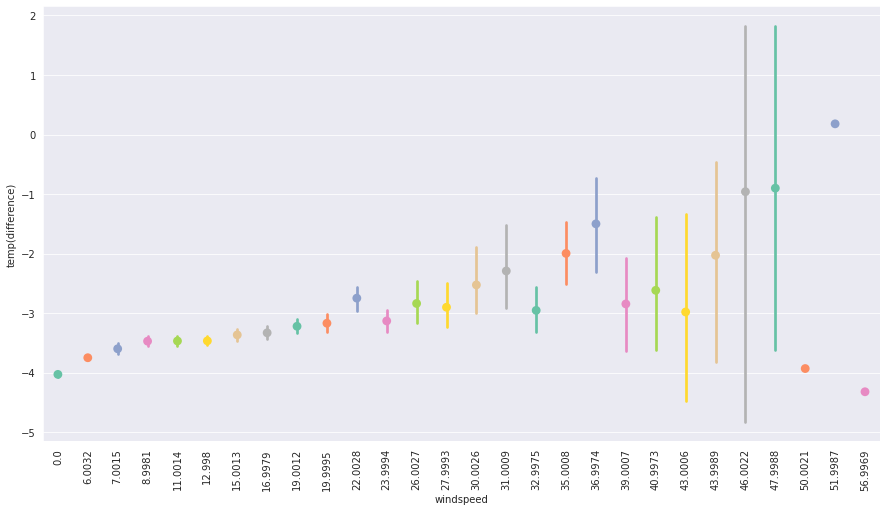

In [19]:
# 파생변수 : 실제 온도와 체감 온도 차이
train['temp(difference)'] = round(train['temp'] - train['atemp'], 2)
test['temp(difference)'] = round(test['temp'] - test['atemp'], 2)

# 풍속과의 연관성
plt.figure(figsize = (15,8))
sns.pointplot(data=train, x="windspeed", y="temp(difference)", palette = 'Set2')
plt.xticks(rotation = 90)
plt.show()

실제 온도와 체감 온도의 차이는 풍속 때문이라고 생각했다. 풍속이 높으면 체감 온도가 더 떨어지기 때문에 temp - atemp는 양수가 나올 것이고, 반대라면 temp - atemp는 큰 차이가 없거나 음수가 나올 것이다.

In [20]:
# 대부분의 데이터가 체감 온도가 높은 것으로 확인됨..
train['temp(difference)'].quantile(0.95)

-1.21

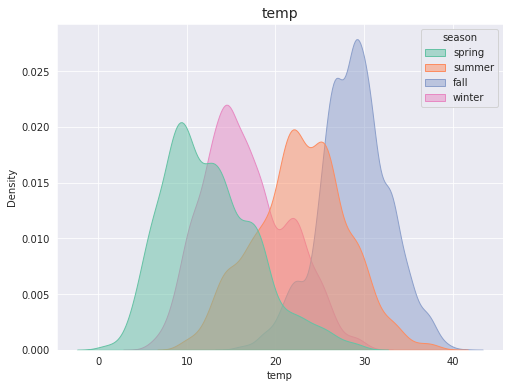

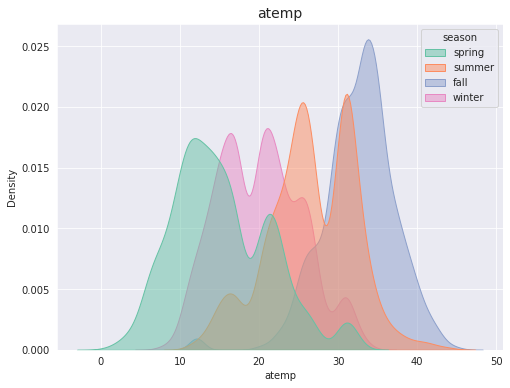

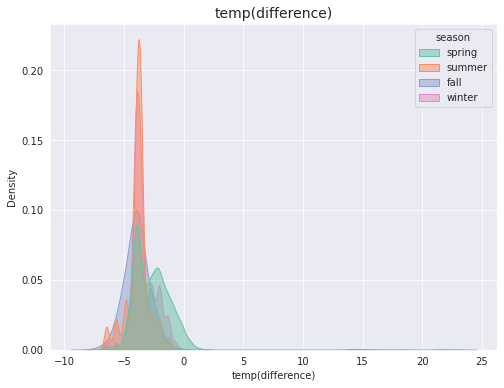

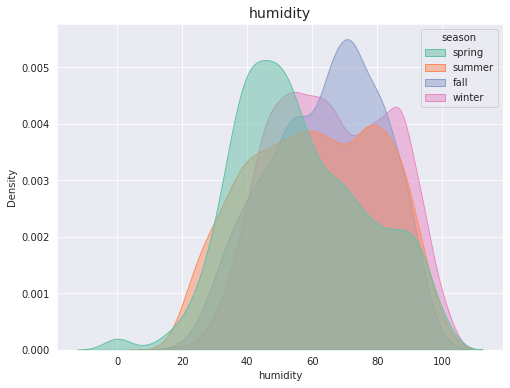

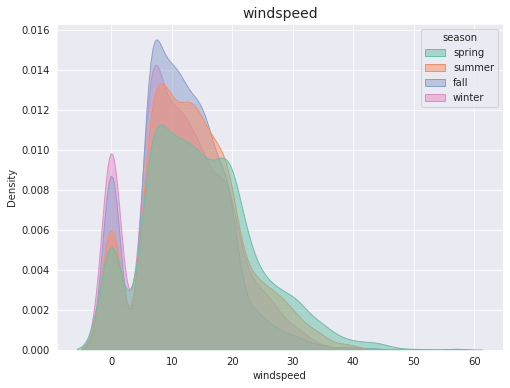

In [21]:
# numerical 변수 kdeplot
cols = ['temp', 'atemp', 'temp(difference)', 'humidity', 'windspeed']
for col in cols:
    plt.figure(figsize = (8,6))
    sns.kdeplot(data = train, x = col, fill = True, hue= 'season', palette='Set2', alpha = .5)
    plt.title(str(col), size = 14)
    plt.show()

- temp와 atemp의 분포에는 살짝 차이가 있는 것으로 보인다.
- 계절에 따라 각 변수마다 차이가 조금씩 있다.
- `windspeed가 0인 날이 꽤 많다. 자세히 봐야겠다.`

## 풍속 처리

In [22]:
#train.query('windspeed==0').head(30)
train.query('windspeed==0').tail(30)

# 풍속이 0인것 또한 유의미하다 생각 ... 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,discomfort_index,peak,temp(difference)
10706,2012-12-12 12:00:00,winter,0,1,2,13.94,18.180,42,0.0,14,218,232,2012,12,12,12,Wednesday,57.38,0,-4.24
10707,2012-12-12 13:00:00,winter,0,1,2,13.94,18.180,42,0.0,18,220,238,2012,12,12,13,Wednesday,57.38,0,-4.24
10708,2012-12-12 14:00:00,winter,0,1,2,13.94,18.180,46,0.0,34,191,225,2012,12,12,14,Wednesday,57.36,0,-4.24
10738,2012-12-13 20:00:00,winter,0,1,1,12.30,16.665,45,0.0,6,235,241,2012,12,13,20,Thursday,55.31,0,-4.36
10739,2012-12-13 21:00:00,winter,0,1,1,11.48,15.910,48,0.0,13,200,213,2012,12,13,21,Thursday,54.19,0,-4.43
10741,2012-12-13 23:00:00,winter,0,1,1,10.66,15.150,60,0.0,5,115,120,2012,12,13,23,Thursday,52.69,0,-4.49
10744,2012-12-14 02:00:00,winter,0,1,1,9.02,13.635,69,0.0,3,6,9,2012,12,14,2,Friday,49.90,0,-4.62
10766,2012-12-15 00:00:00,winter,0,0,1,12.30,16.665,70,0.0,4,90,94,2012,12,15,0,Saturday,54.78,0,-4.36
10768,2012-12-15 02:00:00,winter,0,0,1,10.66,15.150,81,0.0,6,63,69,2012,12,15,2,Saturday,51.90,0,-4.49
10769,2012-12-15 03:00:00,winter,0,0,2,9.84,14.395,81,0.0,5,18,23,2012,12,15,3,Saturday,50.58,0,-4.56


In [23]:
#train.loc['2011-10-01':'2012-11-02']
#2012-12-19 23:00:00	
#train.query(" datetime == '2011-12-19' ")
# datetime 형식으로 index 설정 
train=train.set_index('datetime')
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,discomfort_index,peak,temp(difference)
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,spring,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,Saturday,50.58,0,-4.56
2011-01-01 01:00:00,spring,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,Saturday,49.31,0,-4.62
2011-01-01 02:00:00,spring,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,Saturday,49.31,0,-4.62
2011-01-01 03:00:00,spring,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,Saturday,50.85,0,-4.56
2011-01-01 04:00:00,spring,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,Saturday,50.85,0,-4.56


(array([734655., 734657., 734659., 734661., 734663., 734665., 734667.,
        734669., 734671., 734673.]),
 <a list of 10 Text major ticklabel objects>)

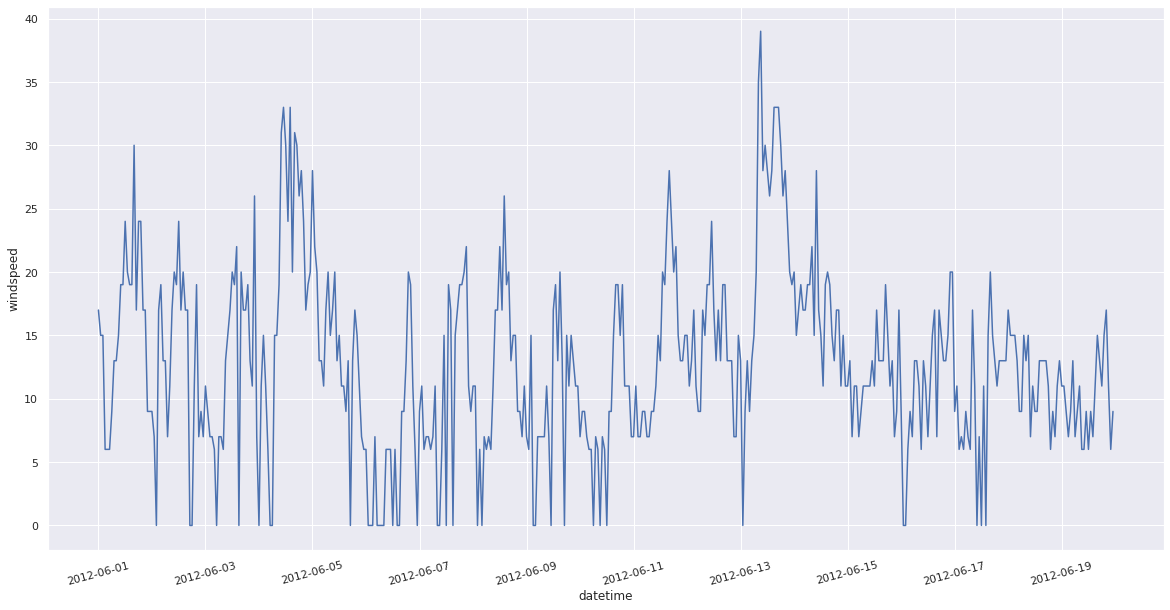

In [24]:
# 시간별 데이터 비교하기 위해 10월 데이터만 뽑아봄 
test = train.loc['2012-6-1':'2012-6-25']

import seaborn as sns
sns.set_theme(style="darkgrid")
plt.figure(figsize = (20,10))

sns.lineplot(x="datetime", y="windspeed",data=test)
plt.xticks(rotation=15)

In [25]:
# 자전거 타기 좋은 날
train['ideal'] = train[['temp', 'windspeed']].apply(lambda x: (0, 1)[15 <= x['temp'] <= 22  and x['windspeed'] < 30], axis = 1)
test['ideal'] = test[['temp', 'windspeed']].apply(lambda x: (0, 1)[15 <= x['temp'] <= 22  and x['windspeed'] < 30], axis = 1)

# 죽어도 자전거 타기 싫은 날
train['sticky'] = train[['humidity', 'temp']].apply(lambda x: (0, 1)[x['temp'] >= 30 and x['humidity'] >= 60], axis = 1)
test['sticky'] = test[['humidity', 'temp']].apply(lambda x: (0, 1)[x['temp'] >= 30 and x['humidity'] >= 60], axis = 1)

In [26]:
train.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,discomfort_index,peak,temp(difference),ideal,sticky
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,spring,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,Saturday,50.58,0,-4.56,0,0
2011-01-01 01:00:00,spring,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,Saturday,49.31,0,-4.62,0,0
2011-01-01 02:00:00,spring,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,Saturday,49.31,0,-4.62,0,0
2011-01-01 03:00:00,spring,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,Saturday,50.85,0,-4.56,0,0
2011-01-01 04:00:00,spring,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,Saturday,50.85,0,-4.56,0,0


In [27]:
train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'day', 'hour', 'dayofweek', 'discomfort_index', 'peak',
       'temp(difference)', 'ideal', 'sticky'],
      dtype='object')

# 변수 선택 
### <파생변수> 
1. discomfort_index 불쾌지수 (temp와 humidity로 생성 ) 
2. ideal 자전거 타기 좋은 날 
3. sticky 자전거 타기 싫은 날  
4. peak (hour와 workingday로 생성) 

###  <현재 존재하는 변수명>

'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'day', 'hour', 'dayofweek', 'discomfort_index', 'ideal',
       'sticky','peak'

- 19개 독립변수 
- 1개 종속변수 


In [28]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek,discomfort_index,peak,temp(difference),ideal,sticky
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,spring,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,Saturday,50.58,0,-4.56,0,0
2011-01-01 01:00:00,spring,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,Saturday,49.31,0,-4.62,0,0
2011-01-01 02:00:00,spring,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,Saturday,49.31,0,-4.62,0,0
2011-01-01 03:00:00,spring,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,Saturday,50.85,0,-4.56,0,0
2011-01-01 04:00:00,spring,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,Saturday,50.85,0,-4.56,0,0


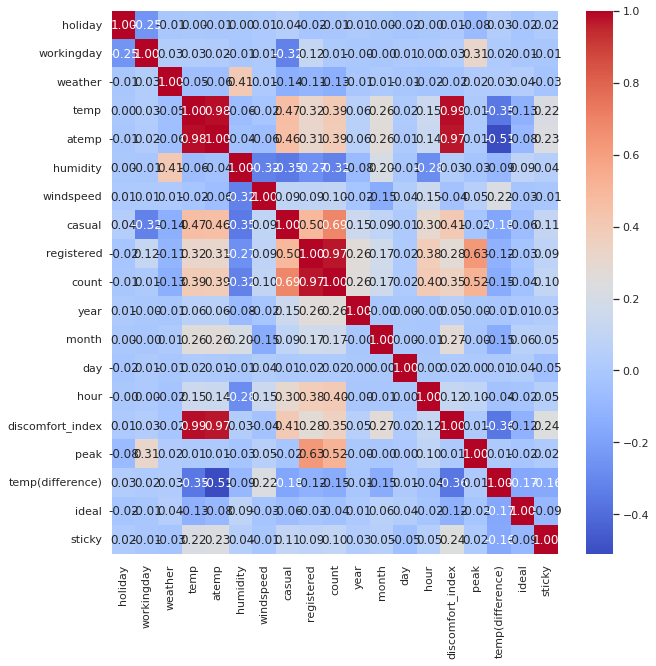

In [29]:
# 상관계수 행렬
plt.figure(figsize = (10,10))

train_numeric = train.loc[:,]
sns.heatmap(train_numeric.corr(), cmap = 'coolwarm', annot = True, fmt= '.2f')
plt.show()

In [30]:
# discomfort_index 선택, temp,atemp 제거 

selected_col = ['holiday', 'weather', 'humidity', 'windspeed', 'casual', 'count', 'year', 'month', 'day', 'hour', 'dayofweek', 'discomfort_index', 'ideal', 'sticky','peak']

train_2 = train[selected_col]
test_2 = test[selected_col]

train_2.head()

,holiday,weather,humidity,windspeed,casual,count,year,month,day,hour,dayofweek,discomfort_index,ideal,sticky,peak
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,81,0.0,3,16,2011,1,1,0,Saturday,50.58,0,0,0
2011-01-01 01:00:00,0,1,80,0.0,8,40,2011,1,1,1,Saturday,49.31,0,0,0
2011-01-01 02:00:00,0,1,80,0.0,5,32,2011,1,1,2,Saturday,49.31,0,0,0
2011-01-01 03:00:00,0,1,75,0.0,3,13,2011,1,1,3,Saturday,50.85,0,0,0
2011-01-01 04:00:00,0,1,75,0.0,0,1,2011,1,1,4,Saturday,50.85,0,0,0


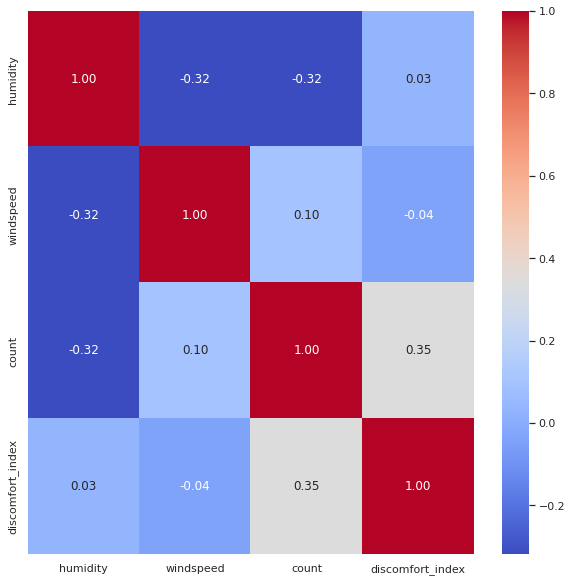

In [31]:
# 상관계수 행렬
# 연속형 변수만 확인 

num_col= ['humidity', 'windspeed', 'count', 'discomfort_index']
plt.figure(figsize = (10,10))

train2_numeric = train_2.loc[:,num_col]
sns.heatmap(train2_numeric.corr(), cmap = 'coolwarm', annot = True, fmt= '.2f')
plt.show()

## peak 변수 검정
- 데이터는 충분히 크므로 정규성은 만족이라는 가정하에 진행한다.
- 가설검정 결과 : 두 집단은 차이가 있으므로 유의미한 변수라 판단 후 진행한다. 

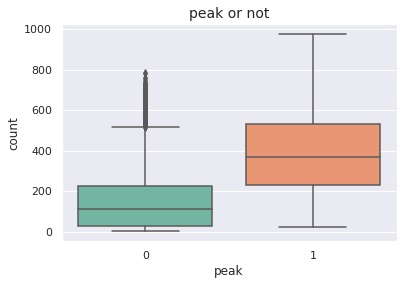

In [32]:
sns.boxplot(data=train_2, x='peak', y='count', palette = 'Set2')
plt.title('peak or not', size = 14)
plt.show()

# 시각화 결과 피크타임에 따른 차이가 있을 것이라 추측 

In [33]:
# 기초통계량 확인 
peak_0 = train_2.query('peak==0')['count']
peak_1 = train_2.query('peak==1')['count'] 

print('peak 타임 X :  평균 {}개의 자전거를 빌려갑니다. '.format(round(peak_0.mean(),2)))
print('peak 타임 X :  분산은 {}입니다. '.format(round(np.var(peak_0,ddof=1),2)))
print('peak 타임 O : 평균 {}개의 자전거를 빌려갑니다. '.format(round(peak_1.mean(),2)))
print('peak 타임 O :  분산은 {}입니다. '.format(round(np.var(peak_1,ddof=1),2)))

peak 타임 X :  평균 148.97개의 자전거를 빌려갑니다. 
peak 타임 X :  분산은 20394.78입니다. 
peak 타임 O : 평균 397.91개의 자전거를 빌려갑니다. 
peak 타임 O :  분산은 41607.96입니다. 


### t-test 
+  Ho : 두 집단의 평균은 같다.
+ 검정하기 앞서 두 분포의 분산 확인해야함 

https://sullma6643.notion.site/sullma6643/72d2053349594c9589625a544b9f161b

In [34]:
!pip install scipy

In [35]:
import scipy

In [36]:
#### 두 분포의 분산 확인 
# Ho : 두 분포의 분산은 같다 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
import scipy.stats as stats

stats.levene(peak_0,peak_1, center='median', proportiontocut=0.05)

# p < 0.05 , Ho 기각  > 두 분포의 분산은 같지 않다. 

LeveneResult(statistic=462.8631272680731, pvalue=1.400618659384108e-100)

In [37]:
## t-test 
# Ho : 두 분포의 평균은 같다
# 이분산성 t-test > equal_var=False 
stats.ttest_ind(peak_0,peak_1, equal_var=False)

# p < 0.05, Ho 기각 > 두 분포의 평균은 같지 않다. 

Ttest_indResult(statistic=-50.19794140921337, pvalue=0.0)

## ideal 변수 검정
- 데이터는 충분히 크므로 정규성은 만족이라는 가정하에 진행한다.
- 가설검정 결과 : ,

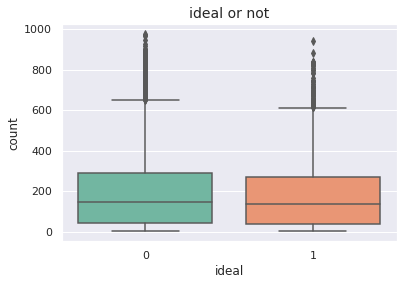

In [38]:
sns.boxplot(data=train_2, x='ideal', y='count', palette = 'Set2')
plt.title('ideal or not', size = 14)
plt.show()

# 시각화 결과 피크타임에 따른 차이가 있을 것이라 추측 

In [39]:
# 기초통계량 확인 
ideal_0 = train_2.query('ideal==0')['count']
ideal_1 = train_2.query('ideal==1')['count'] 

print('ideal 타임 X :  평균 {}개의 자전거를 빌려갑니다. '.format(round(ideal_0.mean(),2)))
print('ideal타임 X :  분산은 {}입니다. '.format(round(np.var(ideal_0,ddof=1),2)))
print('ideal 타임 O : 평균 {}개의 자전거를 빌려갑니다. '.format(round(ideal_1.mean(),2)))
print('ideal 타임 O :  분산은 {}입니다. '.format(round(np.var(ideal_1,ddof=1),2)))

ideal 타임 X :  평균 195.44개의 자전거를 빌려갑니다. 
ideal타임 X :  분산은 34137.73입니다. 
ideal 타임 O : 평균 178.52개의 자전거를 빌려갑니다. 
ideal 타임 O :  분산은 28133.81입니다. 


### t-test 
+  Ho : 두 집단의 평균은 같다.
+ 검정하기 앞서 두 분포의 분산 확인해야함 


In [40]:
#### 두 분포의 분산 확인 
# Ho : 두 분포의 분산은 같다 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
import scipy.stats as stats

stats.levene(ideal_0,ideal_1, center='median', proportiontocut=0.05)

# p < 0.05 , Ho 기각  > 두 분포의 분산은 같지 않다. 

LeveneResult(statistic=19.784469941438545, pvalue=8.754410853584907e-06)

In [41]:
## t-test 
# Ho : 두 분포의 평균은 같다
# 이분산성 t-test > equal_var=False 
stats.ttest_ind(ideal_0,ideal_1, equal_var=False)

# p < 0.05, Ho 기각 > 두 분포의 평균은 같지 않다.

Ttest_indResult(statistic=4.316062546829635, pvalue=1.6230552424656823e-05)

### peak, ideal 두 집단에 따른 count 평균은 다르다 
### 적절한 파생변수를 만들어냈다고 볼 수 있음. 

## Stepwise Forward 단계적 변수 선택법 

In [42]:
df = train_2.copy()
df.head()

,holiday,weather,humidity,windspeed,casual,count,year,month,day,hour,dayofweek,discomfort_index,ideal,sticky,peak
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,81,0.0,3,16,2011,1,1,0,Saturday,50.58,0,0,0
2011-01-01 01:00:00,0,1,80,0.0,8,40,2011,1,1,1,Saturday,49.31,0,0,0
2011-01-01 02:00:00,0,1,80,0.0,5,32,2011,1,1,2,Saturday,49.31,0,0,0
2011-01-01 03:00:00,0,1,75,0.0,3,13,2011,1,1,3,Saturday,50.85,0,0,0
2011-01-01 04:00:00,0,1,75,0.0,0,1,2011,1,1,4,Saturday,50.85,0,0,0


In [43]:
## 전진 단계별 선택법
import statsmodels.api as sm
import matplotlib.pyplot as plt

variables = ['holiday','weather','humidity','windspeed','casual','year','month','day','hour','discomfort_index','ideal','sticky','peak'] ## 설명 변수 리스트
 
y = df['count'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [44]:
selected_variables
# 제거된 변수 : holiday, windspeed, day,sticky

['hour',
 'casual',
 'peak',
 'year',
 'month',
 'humidity',
 'discomfort_index',
 'weather',
 'ideal']

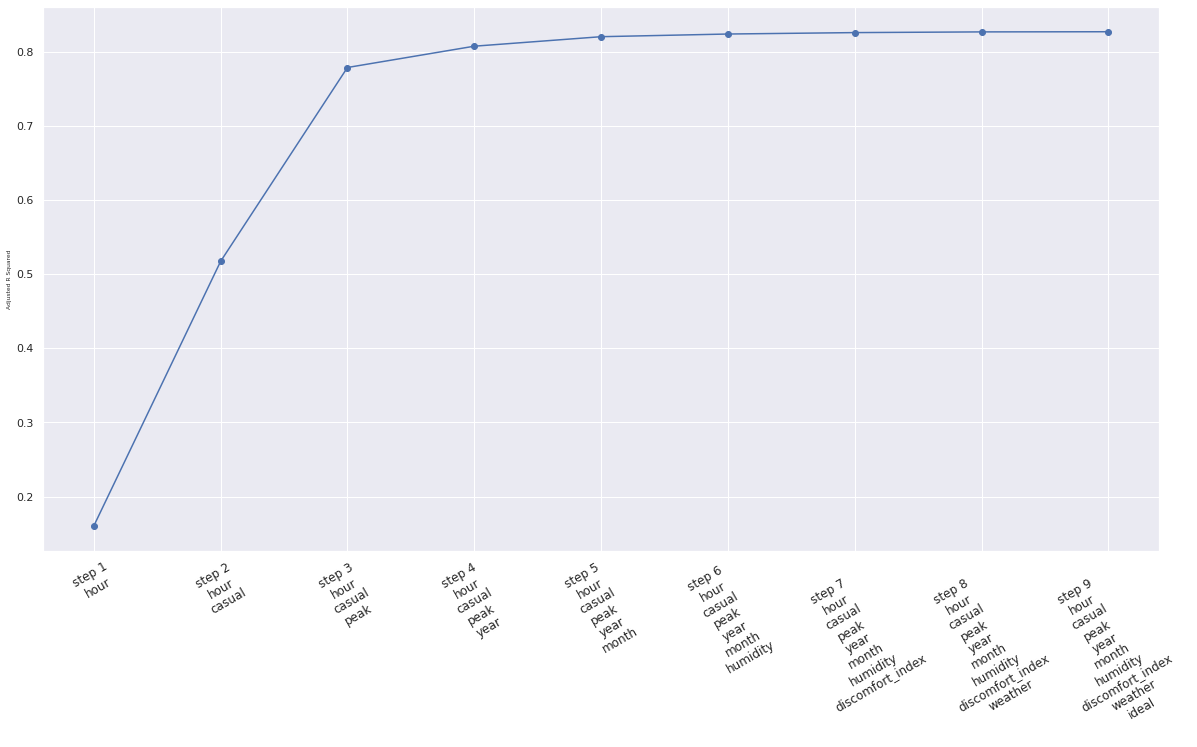

In [45]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')
 
font_size = 6
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()